# 2. Luther – Cleaning and Exploration

## Imports & Versions

In [56]:
import numpy as np
import pandas as pd
import requests
# from bs4 import BeautifulSoup
import pickle
from datetime import datetime, timedelta
import time
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

% matplotlib inline

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# import os
# chromedriver = "/Applications/chromedriver"
# os.environ["webdriver.chrome.driver"] = chromedriver

In [2]:
list_of_imports = [('Numpy', np), 
                   ('Pandas', pd), 
#                   ('Beautiful Soup', BeautifulSoup), 
#                    ('Selenium', webdriver)
                  ]

for mod in list_of_imports:
    print(f"{mod[0]}: {mod[1].__version__}")

print("Python:", sys.version)

Numpy: 1.12.1
Pandas: 0.20.1
Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


## Necessary Functions and Variables

In [3]:
# All the LGA-ORD flights:

flight_urls = [
"http://flightaware.com/live/flight/AAL321/history/20171003/0130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL371/history/20171003/0030Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL359/history/20171002/2330Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL361/history/20171002/2230Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL383/history/20171002/2200Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL345/history/20171002/2130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL343/history/20171002/2030Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL358/history/20171002/1930Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL187/history/20171002/1830Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL332/history/20171002/1730Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL390/history/20171002/1630Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL337/history/20171002/1530Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL328/history/20171002/1430Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL373/history/20171002/1330Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL1619/history/20171002/1230Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL289/history/20171002/1130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL304/history/20171002/1030Z/KLGA/KORD"
]

In [4]:
flights = []
for url in flight_urls:
    fn_p = re.compile(r'AAL\d{3,4}')
    rn_p = re.compile(r'\d{4}Z')
    fn = fn_p.search(url).group()
    rn = rn_p.search(url).group()
    flights.append((fn,rn))

In [ ]:
# helper functions

def diff_minutes(a, b):
    diff = int((a.timestamp() - b.timestamp()) // 60)
    return diff

def day_quarters(dt_obj):
    """
    Given a datetime object, extracts the hour, then returns a number (int)
    0-3 indicating the quarter of the day.
    """
    h = dt_obj.hour
    
    if h < 6:
        q = 0
    elif 6 <= h < 12:
        q = 1
    elif 12 <= h < 18:
        q = 2
    else:
        q = 3
    
    return q

## Cleaning 

For explanations of every single step, scroll down to **Cleaning Prep**.

In [147]:
def clean_it_up(df):
    """
    Includes all the operations necessary to clean and format any dataframe
    of flights, given the following nine columns:
    1. airline: airline as string
    2. f_num: flight number, e.g. AAL321
    3. origin: 3-letter airport code of origin
    4. dest: 3-letter airport code of destination
    5. date: date of flight, datetime.date() object
    6. land_act: actual landing time, datetime object
    7. arr_act: actual gate arrival time, datetime object
    8. land_sch: scheduled landing time, datetime object
    9. arr_sch: scheduled gate arrival time, datetime object
    ---
    IN: pandas dataframe of scraped flight data
    OUT: pandas dataframe, sorted by date and then f_num
    """
    
    types = ['land', 'arr']
    
    # add lateness_land and lateness_arr columns
    for n in types:
        df['lateness_' + n] = (df
         .apply(lambda row: diff_minutes(row[n + '_act'], row[n + '_sch']), axis=1))
    
    # advance land_act and arr_act dates one day if either after midnight
    for n in types:
        df.loc[df['lateness_' + n] < -120, n + '_act'] = (df[n + '_act']
         .apply(lambda x: x + timedelta(days=1)))
    
    # correct lateness values if actual arrivals after midnight
    for n in types:
        col = 'lateness_' + n
        df.loc[(df[col] < -120), col] = df[col] + 1440
    
    # add columns for taxi time
    for n in ['act', 'sch']:
        df['taxi_' + n] = (df
         .apply(lambda row: diff_minutes(row['arr_' + n], row['land_' + n]), axis=1))
        
    # add column for quarter of day
    df['q_of_day'] = df.apply(lambda x: day_quarters(x.arr_sch), axis=1)
    
    # add column for day of week
    df['weekday'] = df.apply(lambda x: x.arr_sch.weekday(), axis=1)
    
    # add four columns where full datetimes are converted to times
    for col in df.columns[5:9]:
        df[col + '_t'] = df.apply(lambda row: row[col].time(), axis=1)
     
    df.sort_values(by=['date', 'f_num'], inplace=True)
    
    return df

In [148]:
with open('../data/AAL_complete.pkl', 'rb') as pf: 
    AAL_raw = pickle.load(pf)

In [149]:
AAL = clean_it_up(AAL_raw)

## Exploration

In [151]:
AAL.head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day,weekday,land_act_t,arr_act_t,land_sch_t,arr_sch_t
1219,American,AAL328,LGA,ORD,2017-03-12,2017-03-12 11:55:00,2017-03-12 12:08:00,2017-03-12 12:18:00,2017-03-12 12:28:00,-23,-20,13,10,2,6,11:55:00,12:08:00,12:18:00,12:28:00
1218,American,AAL328,LGA,ORD,2017-03-13,2017-03-13 12:58:00,2017-03-13 13:12:00,2017-03-13 11:35:00,2017-03-13 12:28:00,83,44,14,53,2,0,12:58:00,13:12:00,11:35:00,12:28:00
1217,American,AAL328,LGA,ORD,2017-03-16,2017-03-16 11:48:00,2017-03-16 11:58:00,2017-03-16 11:19:00,2017-03-16 12:28:00,29,-30,10,69,2,3,11:48:00,11:58:00,11:19:00,12:28:00
1216,American,AAL328,LGA,ORD,2017-03-17,2017-03-17 11:54:00,2017-03-17 12:12:00,2017-03-17 12:09:00,2017-03-17 12:28:00,-15,-16,18,19,2,4,11:54:00,12:12:00,12:09:00,12:28:00
1215,American,AAL328,LGA,ORD,2017-03-19,2017-03-19 11:36:00,2017-03-19 11:54:00,2017-03-19 12:01:00,2017-03-19 12:28:00,-25,-34,18,27,2,6,11:36:00,11:54:00,12:01:00,12:28:00


In [157]:
AAL.describe()

,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day,weekday
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000
mean,17.257780,-0.049793,16.801349,34.108921,2.023859,2.797718
std,52.478107,47.329347,9.102795,21.814464,0.778840,1.971134
min,-49.000000,-58.000000,0.000000,-176.000000,1.000000,0.000000
25%,-18.000000,-24.000000,11.000000,13.000000,1.000000,1.000000
50%,10.000000,-12.000000,16.000000,37.000000,2.000000,3.000000
75%,34.000000,6.000000,20.000000,55.000000,3.000000,4.000000
max,628.000000,609.000000,92.000000,77.000000,3.000000,6.000000


In [164]:
(AAL.sort_values(by='lateness_arr', 
                ascending=False
                )
 .head(10))

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day,weekday,land_act_t,arr_act_t,land_sch_t,arr_sch_t
52,American,AAL371,LGA,ORD,2017-09-06,2017-09-07 08:13:00,2017-09-07 08:20:00,2017-09-06 21:45:00,2017-09-06 22:11:00,628,609,7,26,3,2,08:13:00,08:20:00,21:45:00,22:11:00
19,American,AAL321,LGA,ORD,2017-09-06,2017-09-07 08:16:00,2017-09-07 08:22:00,2017-09-06 22:17:00,2017-09-06 23:09:00,599,553,6,52,3,2,08:16:00,08:22:00,22:17:00,23:09:00
1284,American,AAL373,LGA,ORD,2017-07-12,2017-07-12 17:05:00,2017-07-12 18:05:00,2017-07-12 10:23:00,2017-07-12 11:18:00,402,407,60,55,1,2,17:05:00,18:05:00,10:23:00,11:18:00
466,American,AAL343,LGA,ORD,2017-08-03,2017-08-04 00:43:00,2017-08-04 00:50:00,2017-08-03 17:21:00,2017-08-03 18:26:00,442,384,7,65,3,3,00:43:00,00:50:00,17:21:00,18:26:00
1009,American,AAL337,LGA,ORD,2017-07-12,2017-07-12 17:42:00,2017-07-12 18:45:00,2017-07-12 12:21:00,2017-07-12 13:21:00,321,324,63,60,2,2,17:42:00,18:45:00,12:21:00,13:21:00
741,American,AAL332,LGA,ORD,2017-08-02,2017-08-02 19:27:00,2017-08-02 20:27:00,2017-08-02 15:10:00,2017-08-02 15:20:00,257,307,60,10,2,2,19:27:00,20:27:00,15:10:00,15:20:00
740,American,AAL332,LGA,ORD,2017-08-03,2017-08-03 20:04:00,2017-08-03 20:20:00,2017-08-03 15:53:00,2017-08-03 15:20:00,251,300,16,-33,2,3,20:04:00,20:20:00,15:53:00,15:20:00
103,American,AAL371,LGA,ORD,2017-07-01,2017-07-02 02:27:00,2017-07-02 02:34:00,2017-07-01 21:56:00,2017-07-01 22:13:00,271,261,7,17,3,5,02:27:00,02:34:00,21:56:00,22:13:00
1132,American,AAL328,LGA,ORD,2017-07-12,2017-07-12 16:05:00,2017-07-12 16:33:00,2017-07-12 11:26:00,2017-07-12 12:21:00,279,252,28,55,2,2,16:05:00,16:33:00,11:26:00,12:21:00
1744,American,AAL304,LGA,ORD,2017-05-06,2017-05-06 12:05:00,2017-05-06 12:18:00,2017-05-06 07:12:00,2017-05-06 08:06:00,293,252,13,54,1,5,12:05:00,12:18:00,07:12:00,08:06:00


In [165]:
test = deepcopy(AAL)

In [ ]:
test[]

### Cleaning Prep

In [155]:
with open('../data/AAL343_1003_210250.pkl', 'rb') as pf: 
    df = pickle.load(pf)

Columns with **land** in the title refer to landing time; columns with **arr** in the title refer to gate arrival. The latter is the one officials listed as the arrival time, so I'll be focusing on this one.

In [94]:
df.head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch
0,American,AAL345,LGA,ORD,2017-10-02,2017-10-02 18:45:00,2017-10-02 19:01:00,2017-10-02 19:01:00,2017-10-02 19:16:00
1,American,AAL345,LGA,ORD,2017-10-01,2017-10-01 19:00:00,2017-10-01 19:20:00,2017-10-01 19:02:00,2017-10-01 19:16:00
2,American,AAL345,LGA,ORD,2017-09-29,2017-09-29 18:44:00,2017-09-29 19:01:00,2017-09-29 19:10:00,2017-09-29 19:16:00
3,American,AAL345,LGA,ORD,2017-09-28,2017-09-28 19:11:00,2017-09-28 19:23:00,2017-09-28 19:08:00,2017-09-28 19:16:00
4,American,AAL345,LGA,ORD,2017-09-27,2017-09-27 19:01:00,2017-09-27 19:18:00,2017-09-27 19:06:00,2017-09-27 19:16:00


Creates **lateness_land** and **lateness_arr** column in minutes, where positive indicates late and negative indicates early.

In [109]:
# def diff_minutes(a, b):
#     diff = int((a.timestamp() - b.timestamp()) // 60)
#     return diff

In [96]:
types = ['land', 'arr']

In [97]:
for n in types:
    df['lateness_' + n] = (df
     .apply(lambda row: diff_minutes(row[n + '_act'], row[n + '_sch']), axis=1))

# df['lateness_arr'] = (df
#  .apply(lambda row: diff_minutes(row.arr_act, row.arr_sch), axis=1))

In [98]:
for n in types:
    print(df['lateness_' + n].describe(), '\n')

count    226.000000
mean      23.185841
std       86.810040
min     -998.000000
25%      -14.000000
50%       20.000000
75%       48.750000
max      194.000000
Name: lateness_land, dtype: float64 

count     226.000000
mean        7.000000
std        84.019998
min     -1056.000000
25%       -18.000000
50%        -0.500000
75%        24.750000
max       182.000000
Name: lateness_arr, dtype: float64 



It would be impossible for a plane to be -1056 minutes late (nearly 18 hours early). An investigation...

In [99]:
df.sort_values(by='lateness_arr').head(10)

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr
164,American,AAL343,LGA,ORD,2017-08-03,2017-08-03 00:43:00,2017-08-03 00:50:00,2017-08-03 17:21:00,2017-08-03 18:26:00,-998,-1056
196,American,AAL343,LGA,ORD,2017-06-11,2017-06-11 17:20:00,2017-06-11 17:33:00,2017-06-11 17:17:00,2017-06-11 18:26:00,3,-53
127,American,AAL343,LGA,ORD,2017-09-21,2017-09-21 17:21:00,2017-09-21 17:33:00,2017-09-21 18:04:00,2017-09-21 18:20:00,-43,-47
177,American,AAL343,LGA,ORD,2017-07-09,2017-07-09 17:28:00,2017-07-09 17:40:00,2017-07-09 17:22:00,2017-07-09 18:26:00,6,-46
130,American,AAL343,LGA,ORD,2017-09-16,2017-09-16 17:28:00,2017-09-16 17:35:00,2017-09-16 18:00:00,2017-09-16 18:20:00,-32,-45
187,American,AAL343,LGA,ORD,2017-06-26,2017-06-26 17:36:00,2017-06-26 17:42:00,2017-06-26 17:24:00,2017-06-26 18:26:00,12,-44
188,American,AAL343,LGA,ORD,2017-06-25,2017-06-25 17:36:00,2017-06-25 17:44:00,2017-06-25 17:26:00,2017-06-25 18:26:00,10,-42
182,American,AAL343,LGA,ORD,2017-07-02,2017-07-02 17:35:00,2017-07-02 17:45:00,2017-07-02 17:25:00,2017-07-02 18:26:00,10,-41
195,American,AAL343,LGA,ORD,2017-06-12,2017-06-12 17:34:00,2017-06-12 17:50:00,2017-06-12 17:17:00,2017-06-12 18:26:00,17,-36
73,American,AAL345,LGA,ORD,2017-06-26,2017-06-26 18:39:00,2017-06-26 18:49:00,2017-06-26 18:23:00,2017-06-26 19:24:00,16,-35


One flight didn't get in until the next day, and since FlightAware only lists a time of landing and not the date, it gets stamped with the same date as the scheduled arrival, so the actual arrival in this case seems to be much earlier even though it is almost six hours late.

Adding 24 hours (1440 minutes) will remedy this. Since it's a ~2 hr flight, I will assume that a flight cannot possibly be more than 2 hours early, and will add 1440 to any 'lateness' value less than -120 minutes.

I'll also advance the corresponding arrival date(s) by one day in order to accurately indicate the exact arrival time (not important for regression, but matters with plotting).

First, advancing dates where flights landed and/or arrived after midnight:

In [100]:
for n in types:
    df.loc[df['lateness_' + n] < -120, n + '_act'] = (df[n + '_act']
     .apply(lambda x: x + timedelta(days=1)))

In [102]:
df.sort_values(by='lateness_arr', ascending=True).head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr
164,American,AAL343,LGA,ORD,2017-08-03,2017-08-04 00:43:00,2017-08-04 00:50:00,2017-08-03 17:21:00,2017-08-03 18:26:00,-998,-1056
196,American,AAL343,LGA,ORD,2017-06-11,2017-06-11 17:20:00,2017-06-11 17:33:00,2017-06-11 17:17:00,2017-06-11 18:26:00,3,-53
127,American,AAL343,LGA,ORD,2017-09-21,2017-09-21 17:21:00,2017-09-21 17:33:00,2017-09-21 18:04:00,2017-09-21 18:20:00,-43,-47
177,American,AAL343,LGA,ORD,2017-07-09,2017-07-09 17:28:00,2017-07-09 17:40:00,2017-07-09 17:22:00,2017-07-09 18:26:00,6,-46
130,American,AAL343,LGA,ORD,2017-09-16,2017-09-16 17:28:00,2017-09-16 17:35:00,2017-09-16 18:00:00,2017-09-16 18:20:00,-32,-45


And correcting the lateness values:

In [103]:
for n in types:
    col = 'lateness_' + n
    df.loc[(df[col] < -120), col] = df[col] + 1440
    
# df.loc[(df.lateness_sch < -120), 'lateness_sch'] = df.lateness_sch + 1440

In [107]:
df.iloc[164]

airline                     American
f_num                         AAL343
origin                           LGA
dest                             ORD
date                      2017-08-03
land_act         2017-08-04 00:43:00
arr_act          2017-08-04 00:50:00
land_sch         2017-08-03 17:21:00
arr_sch          2017-08-03 18:26:00
lateness_land                    442
lateness_arr                     384
Name: 164, dtype: object

In [105]:
for n in types:
    print(df['lateness_' + n].describe(), '\n')

count    226.000000
mean      29.557522
std       60.332624
min      -45.000000
25%      -14.000000
50%       20.000000
75%       49.000000
max      442.000000
Name: lateness_land, dtype: float64 

count    226.000000
mean      13.371681
std       51.265790
min      -53.000000
25%      -18.000000
50%        0.000000
75%       25.000000
max      384.000000
Name: lateness_arr, dtype: float64 



**Very interesting that the median lateness_arr is exactly 0** after correcting for the above. One might suppose that the airlines (or at least American) may be scheduling their arrival times such that 50% of the flights are "early." This is just a sample of the entire data set; curious to see if that holds up when all records are accounted for.

Now that arrival dates are corrected, any further subtractions will be legit. I'll make two new columns, one for scheduled taxi time, and one for actual taxi time:

In [110]:
for n in ['act', 'sch']:
    df['taxi_' + n] = (df
     .apply(lambda row: diff_minutes(row['arr_' + n], row['land_' + n]), axis=1))

In [115]:
df.sort_values(by='lateness_arr', ascending=False).head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch
164,American,AAL343,LGA,ORD,2017-08-03,2017-08-04 00:43:00,2017-08-04 00:50:00,2017-08-03 17:21:00,2017-08-03 18:26:00,442,384,7,65
146,American,AAL343,LGA,ORD,2017-08-29,2017-08-29 21:10:00,2017-08-29 21:22:00,2017-08-29 17:58:00,2017-08-29 18:20:00,192,182,12,22
46,American,AAL345,LGA,ORD,2017-08-03,2017-08-03 22:17:00,2017-08-03 22:24:00,2017-08-03 19:03:00,2017-08-03 19:24:00,194,180,7,21
104,American,AAL345,LGA,ORD,2017-05-18,2017-05-18 21:50:00,2017-05-18 22:11:00,2017-05-18 19:05:00,2017-05-18 19:20:00,165,171,21,15
8,American,AAL345,LGA,ORD,2017-09-21,2017-09-21 21:31:00,2017-09-21 21:59:00,2017-09-21 18:58:00,2017-09-21 19:16:00,153,163,28,18


If I want to look at time of day, I'll break the day into quarters based on **arr_sch** and treat TOD categorically.

In [121]:
# def day_quarters(dt_obj):
#     """
#     Given a datetime object, extracts the hour, then returns a number (int)
#     0-3 indicating the quarter of the day.
#     """
#     h = dt_obj.hour
    
#     if h < 6:
#         q = 0
#     elif 6 <= h < 12:
#         q = 1
#     elif 12 <= h < 18:
#         q = 2
#     else:
#         q = 3
    
#     return q

In [124]:
df['q_of_day'] = df.apply(lambda x: day_quarters(x.arr_sch), axis=1)

In [126]:
df.sample(5)

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day
169,American,AAL343,LGA,ORD,2017-07-26,2017-07-26 17:38:00,2017-07-26 18:04:00,2017-07-26 18:16:00,2017-07-26 18:26:00,-38,-22,26,10,3
136,American,AAL343,LGA,ORD,2017-09-10,2017-09-10 17:26:00,2017-09-10 17:58:00,2017-09-10 18:01:00,2017-09-10 18:20:00,-35,-22,32,19,3
224,American,AAL343,LGA,ORD,2017-05-04,2017-05-04 17:35:00,2017-05-04 17:57:00,2017-05-04 16:51:00,2017-05-04 17:42:00,44,15,22,51,2
53,American,AAL345,LGA,ORD,2017-07-24,2017-07-24 19:56:00,2017-07-24 20:13:00,2017-07-24 19:14:00,2017-07-24 19:24:00,42,49,17,10,3
72,American,AAL345,LGA,ORD,2017-06-27,2017-06-27 18:56:00,2017-06-27 19:26:00,2017-06-27 18:23:00,2017-06-27 19:24:00,33,2,30,61,3


I'll need a column to indicate day of the week so I can build dummy columns come time for regression:

In [130]:
df['weekday'] = df.apply(lambda x: x.arr_sch.weekday(), axis=1)

And it may be advantageous to have just the times without the date (for plotting):

In [128]:
for col in df.columns[5:9]:
    df[col+'_t'] = df.apply(lambda row: row[col].time(), axis=1)

In [131]:
df.head(5)

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,taxi_act,taxi_sch,q_of_day,weekday,land_act_t,arr_act_t,land_sch_t,arr_sch_t
0,American,AAL345,LGA,ORD,2017-10-02,2017-10-02 18:45:00,2017-10-02 19:01:00,2017-10-02 19:01:00,2017-10-02 19:16:00,-16,-15,16,15,3,0,18:45:00,19:01:00,19:01:00,19:16:00
1,American,AAL345,LGA,ORD,2017-10-01,2017-10-01 19:00:00,2017-10-01 19:20:00,2017-10-01 19:02:00,2017-10-01 19:16:00,-2,4,20,14,3,6,19:00:00,19:20:00,19:02:00,19:16:00
2,American,AAL345,LGA,ORD,2017-09-29,2017-09-29 18:44:00,2017-09-29 19:01:00,2017-09-29 19:10:00,2017-09-29 19:16:00,-26,-15,17,6,3,4,18:44:00,19:01:00,19:10:00,19:16:00
3,American,AAL345,LGA,ORD,2017-09-28,2017-09-28 19:11:00,2017-09-28 19:23:00,2017-09-28 19:08:00,2017-09-28 19:16:00,3,7,12,8,3,3,19:11:00,19:23:00,19:08:00,19:16:00
4,American,AAL345,LGA,ORD,2017-09-27,2017-09-27 19:01:00,2017-09-27 19:18:00,2017-09-27 19:06:00,2017-09-27 19:16:00,-5,2,17,10,3,2,19:01:00,19:18:00,19:06:00,19:16:00


## Exploratory Plotting

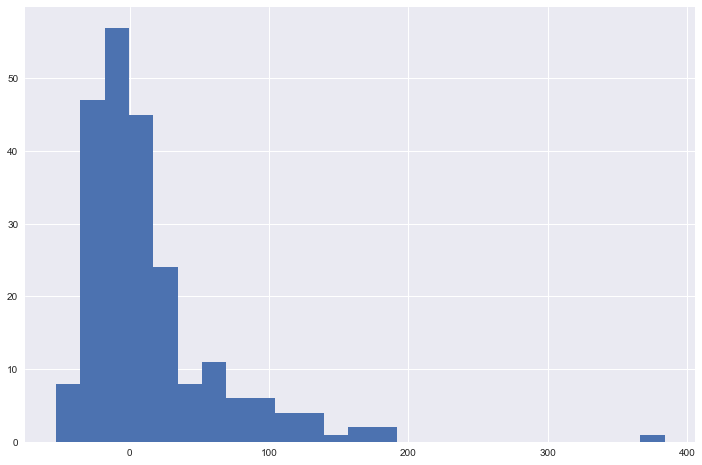

In [132]:
df.lateness_arr.hist(bins=25,figsize=(12,8));

In [ ]:
AAL_test_sorted = df.sort_values(by='date')

In [ ]:
# double plots for both flight nums

x1 = AAL_test_sorted[AAL_test_sorted['f_num'] == 'AAL345'].date
y1 = AAL_test_sorted[AAL_test_sorted['f_num'] == 'AAL345'].arr_act_t
y2 = AAL_test_sorted[AAL_test_sorted['f_num'] == 'AAL345'].arr_sch_t
x2 = AAL_test_sorted[AAL_test_sorted['f_num'] == 'AAL343'].date
y3 = AAL_test_sorted[AAL_test_sorted['f_num'] == 'AAL343'].arr_act_t
y4 = AAL_test_sorted[AAL_test_sorted['f_num'] == 'AAL343'].arr_sch_t

# x = AAL_test_sorted.groupby('date').lateness.mean().index
# y = AAL_test_sorted.groupby('date').lateness.mean()

plt.figure(figsize=(12,8))
# plt.plot(x, y, label="Lateness (negative for early)")
plt.plot(x1, y1, label='Actual arrival (345)')
plt.plot(x1, y2, label='Scheduled arrival (345)')
plt.plot(x2, y3, label='Actual arrival (343)')
plt.plot(x2, y4, label='Scheduled arrival (343)')
plt.legend()
plt.xlabel("Lateness (minutes)")
plt.title("Actual v. Scheduled Arrival (gate)");

In [ ]:
AAL_test_sorted2 = AAL_test.sort_values(by=['weekday', 'date'])

In [ ]:
# again, double for two flights

x = AAL_test_sorted2.weekday
y = AAL_test_sorted2.lateness
# y1 = AAL321_sorted.arr_act_t
# y2 = AAL321_sorted.arr_sch_t

plt.figure(figsize=(12,8))
plt.plot(x, y, "bo", label="Lateness")
# plt.plot(x,y1, "bo", label='Actual arrival')
# plt.plot(x,y2, "bo", label='Scheduled arrival')
plt.legend()
plt.title("Actual v. Scheduled Arrivals (gate), Days of Week");

At first glance, some possible correlation between day of week and ETA, but not enough data to even begin to explore.